# Homework 4: machine learning

---
### NOTE: Sometimes we refer to [the original work](http://nbviewer.jupyter.org/github/mathewzilla/redcard/blob/master/Crowdstorming_visualisation.ipynb) 

---

In [25]:
%load_ext autoreload
%autoreload 2 
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


You need to install `scikit v0.18`: `conda update scikit-learn`

In [26]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, KFold

Read and minimal cleanup: for the first part, we need the labels (i.e. colour ratings), so we can't use the points where they don't exist. 

Since we will later `aggregate` the players, it is **important** to note that this doesn't produce inconsistencies because `dyads` is constructed by a join between a `players` table and a `referees` table, so it is natural that the missing values are missing for all instances of a player.

In [27]:
dyads = pd.read_csv("CrowdstormingDataJuly1st.csv", index_col=0)
print(dyads.shape)

dyads.dropna(subset=['rater1'], inplace=True)
print(dyads.shape)

# since both values are missing at the same time, this should be 0:
print(dyads.rater2.isnull().sum())

# the groupby object user later on
group_players = dyads.groupby(level=0)

(146028, 27)
(124621, 27)
0


In [28]:
dyads.head()

,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
playerShort,,,,,,,,,,,,,,,,,,,,,
lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,0,...,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,0,...,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,0,...,0.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,10.11.1985,187.0,80.0,Left Fullback,1,1,0,...,0.25,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
alexander-tettey,Alexander Tettey,Norwich City,England,04.04.1986,180.0,68.0,Defensive Midfielder,1,0,0,...,1.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752


Let's see the numbers: 

<sub>yes, they were done by the other guys, but it's useful to have them at hand:</sub>

Also, they were excluding some referees that have been _carried over_, and that only removes ~3% of the data. Since we're not doing statistics on referees, we won't drop them. Every little data helps :)

In [29]:
print("Number of players: " , dyads.index.unique().size)
print("Number of referees: ", dyads.refNum.unique().size)

Number of players:  1585
Number of referees:  2978


The original analysis mentioned that "*the two raters disagree on 28742 or 19% of the time*". Since there are only 1585 players, it means they ran it on the `dyads` set. _**WHY?**_ That doesn't make sense, so let's just check that the ratings for each player are consistent:

for the group of each player, we check that the number of values in `raterX` is **exactly** one:

In [30]:
def build_player_consitency(player_df):
    """ Needs to return a Series of {col_name: col_value}. """
    return pd.Series({col+"_INconsistent" : (player_df[col].unique().size != 1) 
                                             for col in ['rater1', 'rater2'] })
consistency = group_players.apply(build_player_consitency)
print(consistency.head())
print("Rater1 has been inconsistent %d times" % consistency.rater1_INconsistent.sum())
print("Rater2 has been inconsistent %d times" % consistency.rater2_INconsistent.sum())

                       rater1_INconsistent rater2_INconsistent
playerShort                                                   
aaron-hughes                         False               False
aaron-hunt                           False               False
aaron-lennon                         False               False
aaron-ramsey                         False               False
abdelhamid-el-kaoutari               False               False
Rater1 has been inconsistent 0 times
Rater2 has been inconsistent 0 times


OK, so they _ARE_ consistent. This means that their statistic doesn't account for players who have more matches than others, so the numbers are skewed. Let's check again, this time on _unique_ players

In [31]:
player_ratings = group_players.agg({'rater1':'first', 'rater2':'first'})
diffs = player_ratings.rater1 - player_ratings.rater2
print("The raters disagree for {p:.3f}% of the players".format(p=(diffs != 0).sum() / len(diffs) ))

print("Diffs std dev: ", diffs.std())

max_diff = diffs.abs().max()
num_occur = (diffs.abs() == max_diff).sum()
print("Max disagreement value {0}, occuring {1} times".format(max_diff * 4, num_occur)) # *4 to pass from float to int

The raters disagree for 0.239% of the players
Diffs std dev:  0.11594303556667578
Max disagreement value 2.0, occuring 2 times


So this means:
  1. that there is slightly more agreement between the raters for players who have more entries in `dyads` i.e. who played under more referees
  2. that if we use both labels, using `accuracy` as a measure of performance is not a very good idea. Keep in mind that the differences are not ordered, so it could have an impact double as big on the accuracy, i.e. at most $1 - 2 * \mathit{disagreementPercentage} = 1 - 2 * 0.24 \approx 0.5 $

#### Curiosity
Who are the 'controversial' guys :) ?

In [32]:
diffs[diffs.abs() == max_diff]

playerShort
kyle-walker    -0.5
mario-goetze   -0.5
dtype: float64

<img style='float:left' alt='Kyle-walker' src='http://www.thefootballsocial.co.uk/images/players/Tottenham%20Hotspur/Kyle%20Walker.jpg' /> <img alt='Mario_Goetze' src='http://i0.web.de/image/176/31756176,pd=2/mario-goetze.jpg' width=300/>

## Feature selection

Aggregate the data for each player we consider the following variables:
- the height and weight of the player
- The total amount of games played
- The total amount of victories, ties and defeats
- the total number of goals made
- The total number of red cards, yellow reds and yellow cards received
- The respective ratings
- The league country

In [33]:
players = group_players.agg({'height':'first', 'weight':'first', 'games':'sum', 
                             'victories':'sum','defeats':'sum', 'ties': 'sum', 'goals':'sum', 
                             'redCards':'sum', 'yellowReds': 'sum', 'yellowCards':'sum', 
                             'leagueCountry':'first', 'rater1':'median', 'rater2':'median'})
print(players.shape)
players.head()

(1585, 13)


,rater2,height,yellowReds,defeats,weight,redCards,ties,goals,victories,leagueCountry,rater1,games,yellowCards
playerShort,,,,,,,,,,,,,
aaron-hughes,0.00,182.0,0,228,71.0,0,179,9,247,England,0.25,654,19
aaron-hunt,0.25,183.0,0,122,73.0,1,73,62,141,Germany,0.00,336,42
aaron-lennon,0.25,165.0,0,115,63.0,0,97,31,200,England,0.25,412,11
aaron-ramsey,0.00,178.0,0,68,76.0,1,42,39,150,England,0.00,260,31
abdelhamid-el-kaoutari,0.25,180.0,4,43,73.0,2,40,1,41,France,0.25,124,8


There are some leftover values with null in the weight and height columns

In [34]:
players.isnull().sum()

rater2            0
height            3
yellowReds        0
defeats           0
weight           21
redCards          0
ties              0
goals             0
victories         0
leagueCountry     0
rater1            0
games             0
yellowCards       0
dtype: int64

If the weight or the height is NaN we replace it by the median height and weight of all the players (switch_median = True). As an alternative the replacement can be done using the average (switch_median = False)

In [35]:
switch_median = True
if(switch_median):
    med_height = players['height'].median()
    med_weight = players['weight'].median()
    players['height'] = players['height'].fillna(value=av_height)
    players['weight'] = players['weight'].fillna(value=av_weight)
else:
    av_height = players['height'].mean()
    av_weight = players['weight'].mean()
    players['height'] = players['height'].fillna(value=av_height)
    players['weight'] = players['weight'].fillna(value=av_weight)

Create dummy variables from leagueCountry (categorical) feature. After adding the dummy variables indicating in which country the player plays and removing the feature with the actual strings we have to take care of the dummy variable trap. In essence we have 4 countries but if we keep all for them it will be redundant as we can infer one country from the other 3, and such one feature is linearly dependent on the other 3. (for more information: http://www.algosome.com/articles/dummy-variable-trap-regression.html) 

In [36]:
leagueCountries_dummies = pd.get_dummies(players['leagueCountry'])
players = pd.concat([players, leagueCountries_dummies], axis=1)      
players.drop(['leagueCountry', 'Spain'], inplace=True, axis=1)
players.head()

,rater2,height,yellowReds,defeats,weight,redCards,ties,goals,victories,rater1,games,yellowCards,England,France,Germany
playerShort,,,,,,,,,,,,,,,
aaron-hughes,0.00,182.0,0,228,71.0,0,179,9,247,0.25,654,19,1.0,0.0,0.0
aaron-hunt,0.25,183.0,0,122,73.0,1,73,62,141,0.00,336,42,0.0,0.0,1.0
aaron-lennon,0.25,165.0,0,115,63.0,0,97,31,200,0.25,412,11,1.0,0.0,0.0
aaron-ramsey,0.00,178.0,0,68,76.0,1,42,39,150,0.00,260,31,1.0,0.0,0.0
abdelhamid-el-kaoutari,0.25,180.0,4,43,73.0,2,40,1,41,0.25,124,8,0.0,1.0,0.0


Convert the new added dummy variables from float to int

In [37]:
players['England'] = players['England'].astype(int)
players['France'] = players['France'].astype(int)
players['Germany'] = players['Germany'].astype(int)

In [38]:
players.head()

,rater2,height,yellowReds,defeats,weight,redCards,ties,goals,victories,rater1,games,yellowCards,England,France,Germany
playerShort,,,,,,,,,,,,,,,
aaron-hughes,0.00,182.0,0,228,71.0,0,179,9,247,0.25,654,19,1,0,0
aaron-hunt,0.25,183.0,0,122,73.0,1,73,62,141,0.00,336,42,0,0,1
aaron-lennon,0.25,165.0,0,115,63.0,0,97,31,200,0.25,412,11,1,0,0
aaron-ramsey,0.00,178.0,0,68,76.0,1,42,39,150,0.00,260,31,1,0,0
abdelhamid-el-kaoutari,0.25,180.0,4,43,73.0,2,40,1,41,0.25,124,8,0,1,0


We standardize the data. Some features, like the newly added dummy variables do not make much sense to be standardized.

In [39]:
features_to_be_standardized = ['height','yellowReds','defeats','redCards','ties','weight',
                              'goals','yellowCards','games','victories']

def standardize(feature_names):
    for feature_name in feature_names:
        players[feature_name] = \
        (players[feature_name] - players[feature_name].mean()) / players[feature_name].std()

standardize(features_to_be_standardized)
players.head()

,rater2,height,yellowReds,defeats,weight,redCards,ties,goals,victories,rater1,games,yellowCards,England,France,Germany
playerShort,,,,,,,,,,,,,,,
aaron-hughes,0.00,-0.006568,-0.682282,3.745172,-0.713278,-0.749238,3.600697,-0.452545,1.823256,0.25,2.935828,-0.494788,1,0,0
aaron-hunt,0.25,0.141876,-0.682282,1.174141,-0.429923,-0.001886,0.492236,0.824019,0.456776,0.00,0.705694,0.424086,0,0,1
aaron-lennon,0.25,-2.530129,-0.682282,1.004356,-1.846696,-0.749238,1.196039,0.077349,1.217364,0.25,1.238682,-0.814397,1,0,0
aaron-ramsey,0.00,-0.600347,-0.682282,-0.135629,-0.004892,-0.001886,-0.416842,0.270038,0.572798,0.00,0.172706,-0.015375,1,0,0
abdelhamid-el-kaoutari,0.25,-0.303458,2.195740,-0.742004,-0.429923,0.745466,-0.475492,-0.645234,-0.832357,0.25,-0.781062,-0.934250,0,1,0


## Assignment 2: cluster players

We convert the pandas data frame to lists in order to match the expected data format for scikit learn.

Main parameters to consider for kmeans clusterer

- max_iter : int, default: 300
Maximum number of iterations of the k-means algorithm for a single run.

- n_init : int, default: 10
Number of time the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of inertia.

- init : {‘k-means++’, ‘random’ or an ndarray}
Method for initialization, defaults to ‘k-means++’:
‘k-means++’ : selects initial cluster centers for k-mean clustering in a smart way to speed up convergence. See section Notes in k_init for more details.
‘random’: choose k observations (rows) at random from data for the initial centroids.
If an ndarray is passed, it should be of shape (n_clusters, n_features) and gives the initial centers.

- algorithm : “auto”, “full” or “elkan”, default=”auto”
K-means algorithm to use. The classical EM-style algorithm is “full”. The “elkan” variation is more efficient by using the triangle inequality, but currently doesn’t support sparse data. “auto” chooses “elkan” for dense data and “full” for sparse data.

In [40]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

Generate feature subsets on which to run the kmeans clusterer

In [18]:
from itertools import chain, combinations
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

For completeness it would be ideal to test all feature subsets and find which one has a better silhouette score and in this case in the pick_subset function the lower bound limit should be 1 (the empty set is ignored). However this would require a lot of computation time so the number of feature subsets can be reduced by selecting different bounds on the length of the feature subset.

In [44]:
upper_bound = 15
lower_bound = 11
def pick_subset(element):
    return len(element) >= lower_bound and len(element) <= upper_bound

def prepare_feature_subsets(features):
    return filter(pick_subset, features)

Create all the feature subsets using powerset on the column names, afterwards perform the selection step to reduce the number of subsets

In [45]:
feature_subsets = list(prepare_feature_subsets(list(powerset(players.columns.values))))

In [43]:
len(feature_subsets)

1941

Run the clusterer on each feature subset

In [46]:
def run_clusterer():
    estimator = KMeans(n_clusters=2, random_state=0)
    counter = 0
    best_silhouette = -1
    best_feature_subset = feature_subsets[0]
    for feature_subset in feature_subsets:
        X = players[list(feature_subset)]
        estimator.fit(X)
        silhouette_avg = silhouette_score(X, estimator.labels_)
        if(counter % 500 == 0):
            print("Counter ", counter)
            print("For n_clusters =", 2, "The average silhouette_score is :", silhouette_avg)
        counter += 1
        if(silhouette_avg > best_silhouette):
            best_silhouette = silhouette_avg
            best_feature_subset = feature_subset
    return best_feature_subset

In [47]:
best_features = run_clusterer()

Counter  0
For n_clusters = 2 The average silhouette_score is : 0.317903238031
Counter  500
For n_clusters = 2 The average silhouette_score is : 0.305209927551
Counter  1000
For n_clusters = 2 The average silhouette_score is : 0.386835432845
Counter  1500
For n_clusters = 2 The average silhouette_score is : 0.318189195083


The best feature subset on the silhouette score was saved during the previous computation and now we can see how well it performed.

In [48]:
estimator = KMeans(n_clusters=2, random_state=0)
X = players[list(best_features)]
estimator.fit(X.as_matrix())
silhouette_avg = silhouette_score(X, estimator.labels_)
print("For n_clusters =", 2, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.403322489449


Small test to make sure there is no difference between calling estimator.labels_ vs. estimator.predict()

In [50]:
# should be True as in no difference between calling estimator.labels_ and using estimator.predict(X)
X_pred = estimator.predict(X)
np.sum(np.array(X_pred) - np.array(estimator.labels_)) == 0

True

NOTE: Here I am not exactly sure how to compare the above clustering labels with the skin color-tone ratings

Make a dataframe containing the average rating ((rater1 + rater2) / 2) and the cluster labels obtained after running KMeans.

In [51]:
player_clusters = players[["rater1", "rater2"]]
labels = pd.Series(estimator.labels_, index=player_clusters.index)
player_clusters = player_clusters.assign(labels=labels.values)
player_clusters['average_rating'] = players[["rater1", "rater2"]].mean(axis=1)
player_clusters.drop(['rater1', 'rater2'], inplace=True, axis=1)
player_clusters.head()

,labels,average_rating
playerShort,,
aaron-hughes,1,0.125
aaron-hunt,1,0.125
aaron-lennon,1,0.250
aaron-ramsey,0,0.000
abdelhamid-el-kaoutari,0,0.250


Perform a mapping in the average_rating column where each value >= 0.5 gets converted to 1 and all values < 0.5 get converted to 0.

In [ ]:
player_clusters['average_rating'] = \
    player_clusters['average_rating'].apply(lambda x: 1 if x >= 0.5 else 0)
player_clusters.head()

In [52]:
grouped_clusters = player_clusters.groupby('labels')
grouped_cls = grouped_clusters.agg({'average_rating':['count','mean']})
grouped_cls

average_rating          
                count      mean
labels                         
0                1057  0.296121
1                 528  0.276278

### Cluster visualization using PCA dimension reduction

Reduced data represents the projection of the data on the 2 directions  with maximal variance as computed by PCA. Why 2? because it is easier in doing the visualization.

In [56]:
from sklearn.decomposition import PCA

# pass the matrix containing the features you want to test in fit_transform
# NOTE: X represents the best features under the silhouette score in the previous computation 
reduced_data = PCA(n_components=2).fit_transform(X.as_matrix())
kmeans = KMeans(init='k-means++', n_clusters=2)
kmeans.fit(reduced_data)
print(reduced_data.shape)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

(1585, 2)


In [57]:
# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
Z = Z.reshape(xx.shape)

In [58]:
# get the average rating of the players into a list to process it easier afterwards
average_rating = player_clusters['average_rating'].tolist()

Divide the reduced data into 2 subsets:
- reduced data where the corresponding players have an average rating >= 0.5
- reduced data where the corresponding players have an average rating < 0.5

In [59]:
from itertools import compress
def restructure_reduced_data(red_data, avg_rating):
    index_dark = []
    index_light = []
    for i in range(len(avg_rating)):
        if(avg_rating[i] >= 0.5):
            index_dark.append(i)
        else:
            index_light.append(i)
    return red_data[index_dark], red_data[index_light]

(reduced_data_dark, reduced_data_light) = restructure_reduced_data(reduced_data, average_rating)

# Should be 'True' to make sure the dimensions of the subsets correspond to the dimensions of the original 
reduced_data_dark.shape[0]+reduced_data_light.shape[0] == reduced_data.shape[0]

True

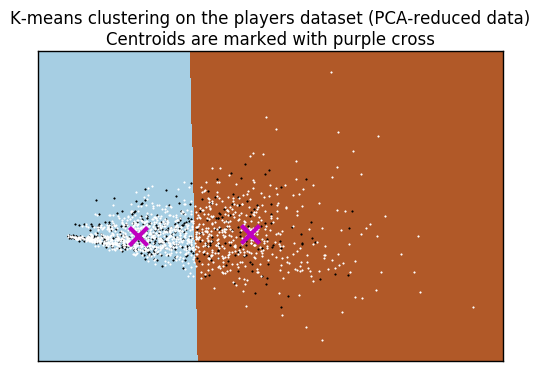

In [60]:
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data_dark[:, 0], reduced_data_dark[:, 1], 'k.', markersize=2)
plt.plot(reduced_data_light[:, 0], reduced_data_light[:, 1], 'w.', markersize=2)

# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='m', zorder=10)
plt.title('K-means clustering on the players dataset (PCA-reduced data)\n'
          'Centroids are marked with purple cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()